<a href="https://colab.research.google.com/github/reitezuz/18NES2-2025/blob/main/week_07/cnn_architecture_patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Architecture patterns  - From Residual to Xception

Based on https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter09_convnet-architecture-patterns.ipynb

In this notebook, we explore several key **design patterns used in modern convolutional neural networks (CNNs)**.

The goal is to understand how common architectural ideas — such as **residual connections** and **depthwise separable convolutions** — improve model performance and efficiency.

We will:
- Build and visualize small CNN examples using the **Keras Functional API**
- Explore different types of **residual blocks**:
  - Identity shortcut (same dimensions)
  - Projection shortcut (changing filter count)
  - Downsampling shortcut (with pooling)
- Introduce **depthwise separable convolutions**, the core idea behind *Xception* and *MobileNet*
- Combine these patterns into a compact CNN inspired by **Xception**

> These building blocks form the foundation of many state-of-the-art architectures such as ResNet, Xception, MobileNet, and EfficientNet.


## Residual Block with Identity Shortcut (Same Dimensions)
- This is the simplest form of a residual block —
the main path and the shortcut have the same dimensions (no need for projection).
- It illustrates the core idea of residual learning: adding the input (residual) back to the output of a few convolutional layers.

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 30, 30,    │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 30, 30,    │      9,248 │ conv2d_9[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 30, 30,    │      9,248 │ conv2d_10[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 30, 30,    │          0 │ conv2d_11[0][0],  │
│                     │ 32)               │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 28800)     │          0 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │     86,403 │ flatten_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 105,795 (413.26 KB)

 Trainable params: 105,795 (413.26 KB)

 Non-trainable params: 0 (0.00 B)

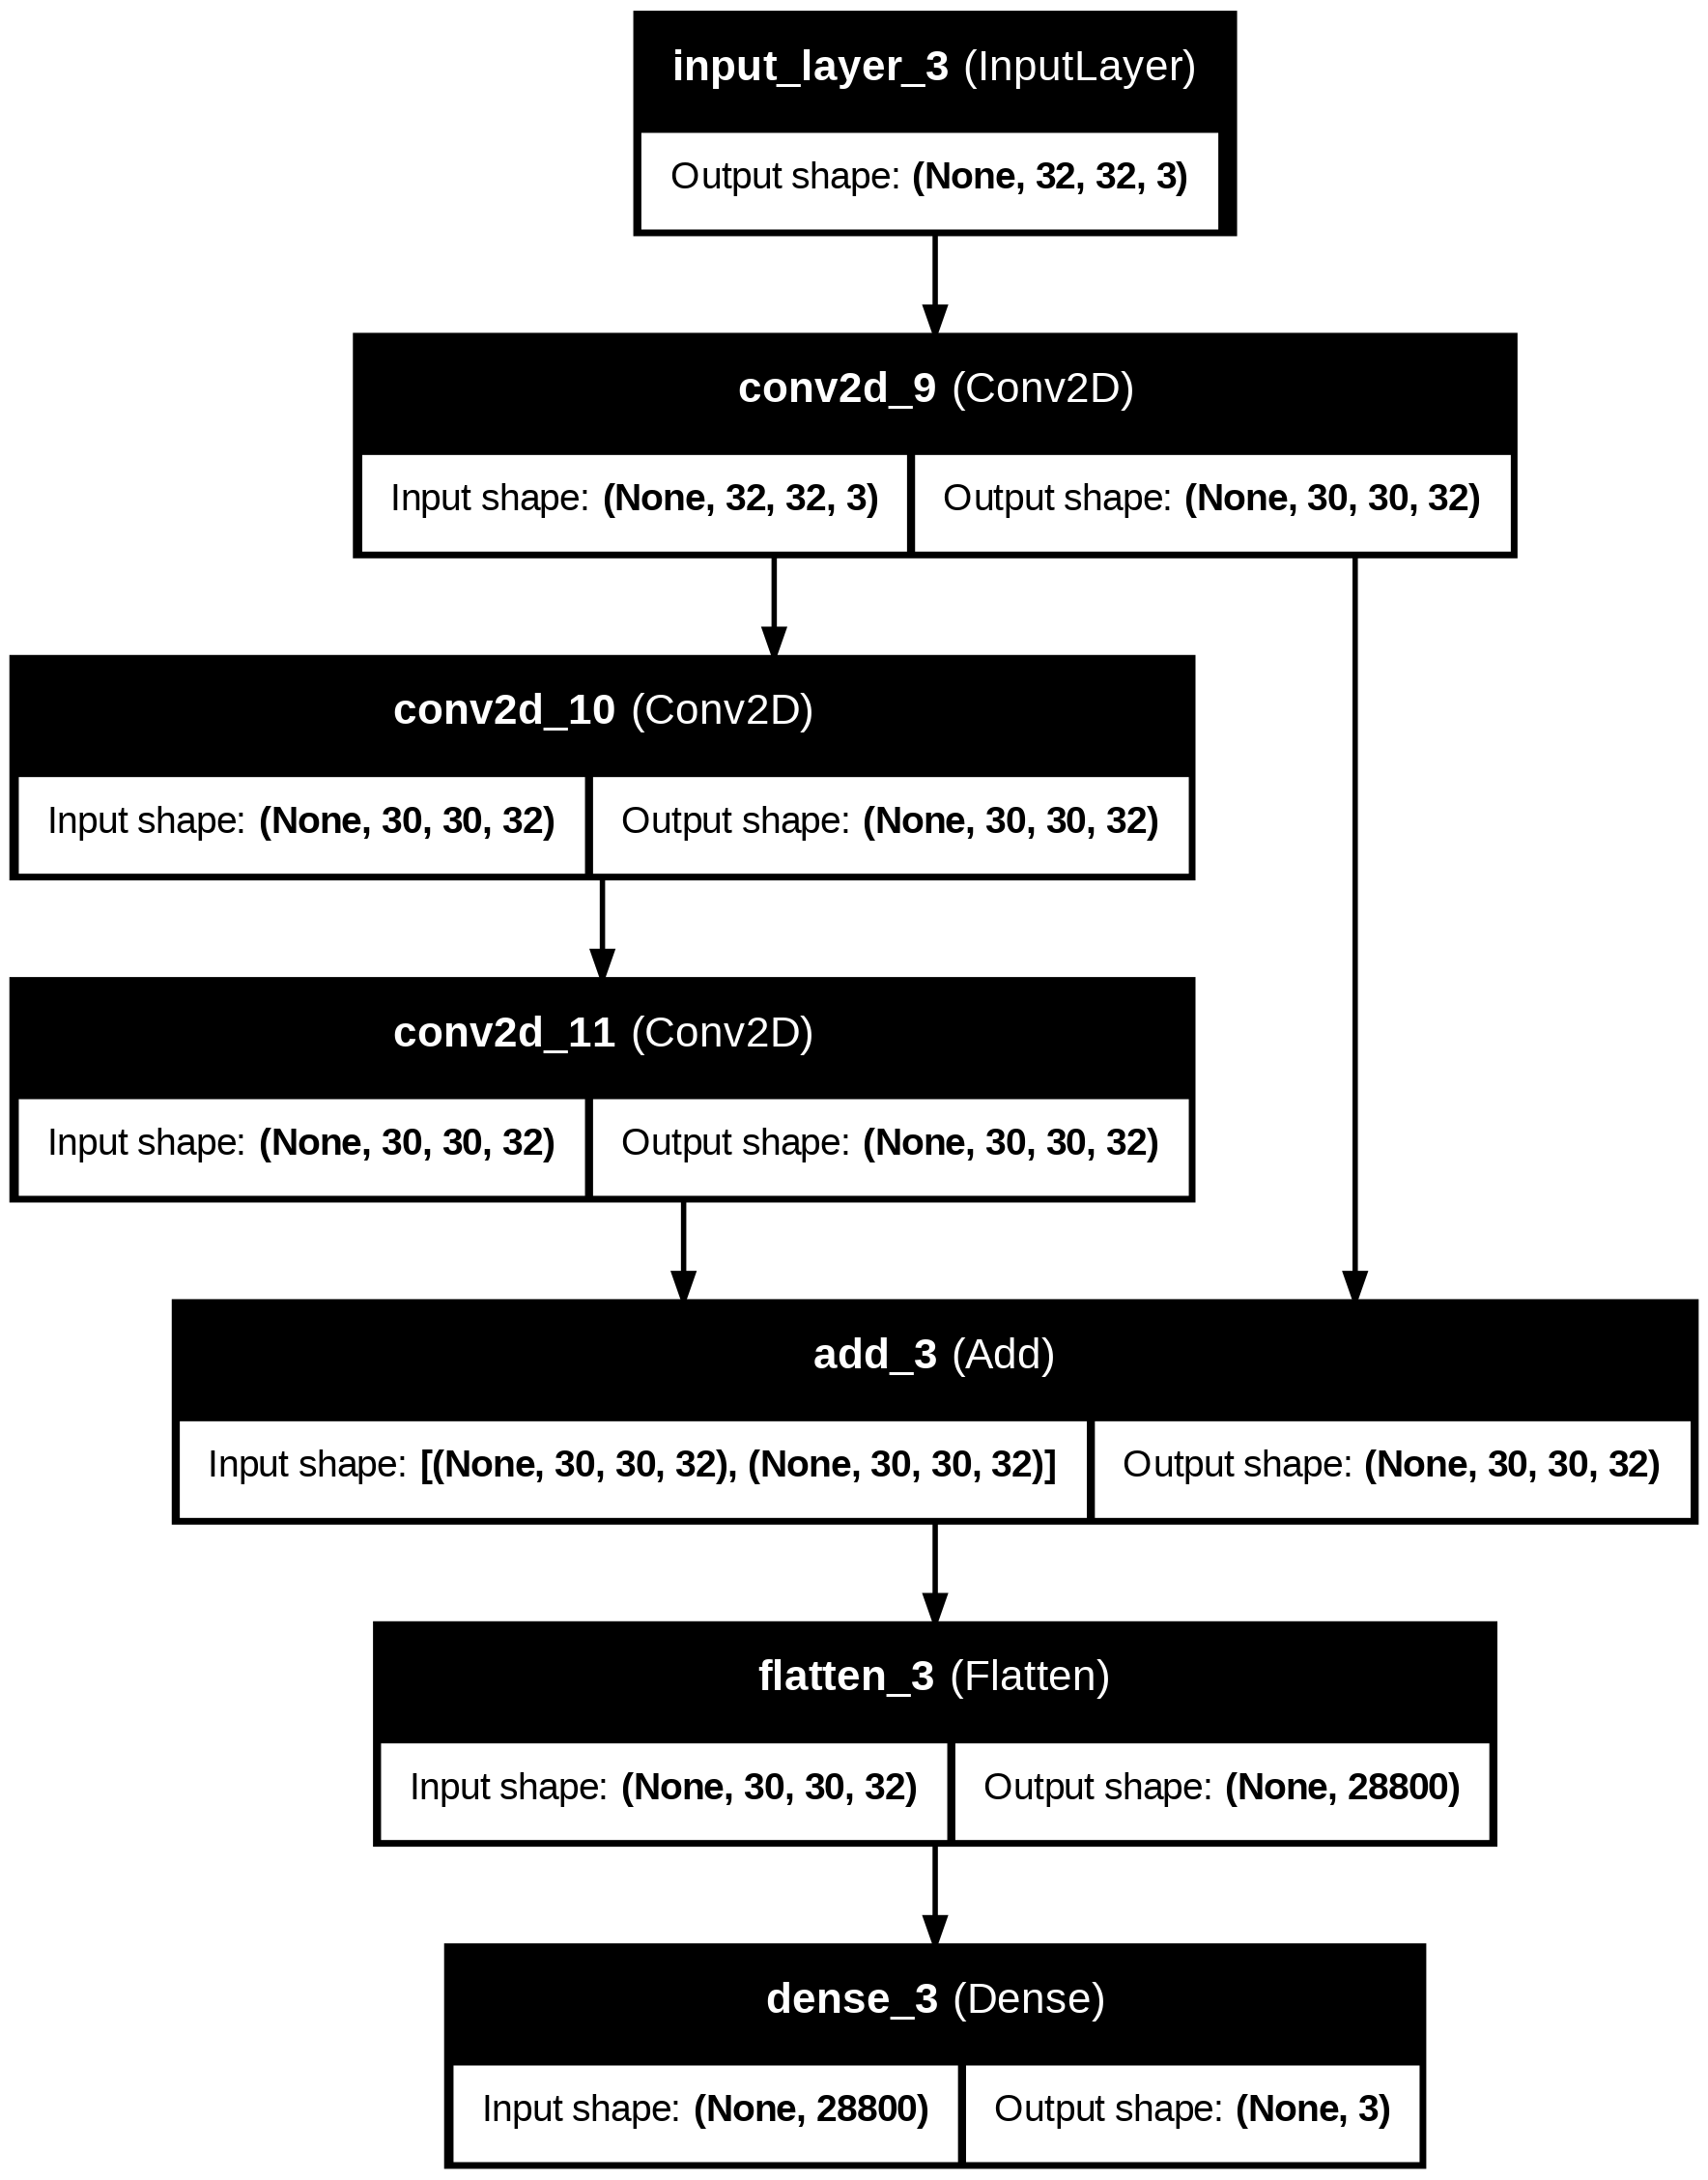

In [ ]:
import keras

# Input layer: RGB image 32×32
inputs = keras.layers.Input(shape=(32, 32, 3))

# Convolutional layer
x = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
residual = x      # save this as the shortcut connection (residual)

# Main path
# Layers that do not change the spatial or depth dimensions
x = keras.layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = keras.layers.Conv2D(32, 3, activation="relu", padding="same")(x)

# Add the main and shortcut paths together
x = keras.layers.Add()([x, residual])

# Head of the model
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(3, activation='softmax')(x)

# Create the model
model = keras.models.Model(inputs=inputs, outputs=outputs)

# Display the model summary
model.summary()

keras.utils.plot_model(model, to_file="functional_model.png", show_shapes=True, show_layer_names=True)
from IPython.display import Image, display
display(Image(filename="functional_model.png", width=800))

### Notes
- This is an **identity shortcut**: the shortcut path is simply the input itself (x),
because both branches have the same shape (32 filters, same spatial size).
- This type of block is used when depth and resolution remain constant.
- Adding the shortcut helps preserve information and enables deeper networks to train efficiently.

## Simple residual block
- This example shows how to implement a residual connection in Keras when the number of filters changes between layers.
- Since the shortcut connection (residual) must match the shape of the main path, we use a 1×1 convolution to adjust its depth (number of channels).

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 30, 30,    │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 30, 30,    │     18,496 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 30, 30,    │      2,112 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 30,    │          0 │ conv2d_4[0][0],   │
│                     │ 64)               │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 57600)     │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │    172,803 │ flatten_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 194,307 (759.01 KB)

 Trainable params: 194,307 (759.01 KB)

 Non-trainable params: 0 (0.00 B)

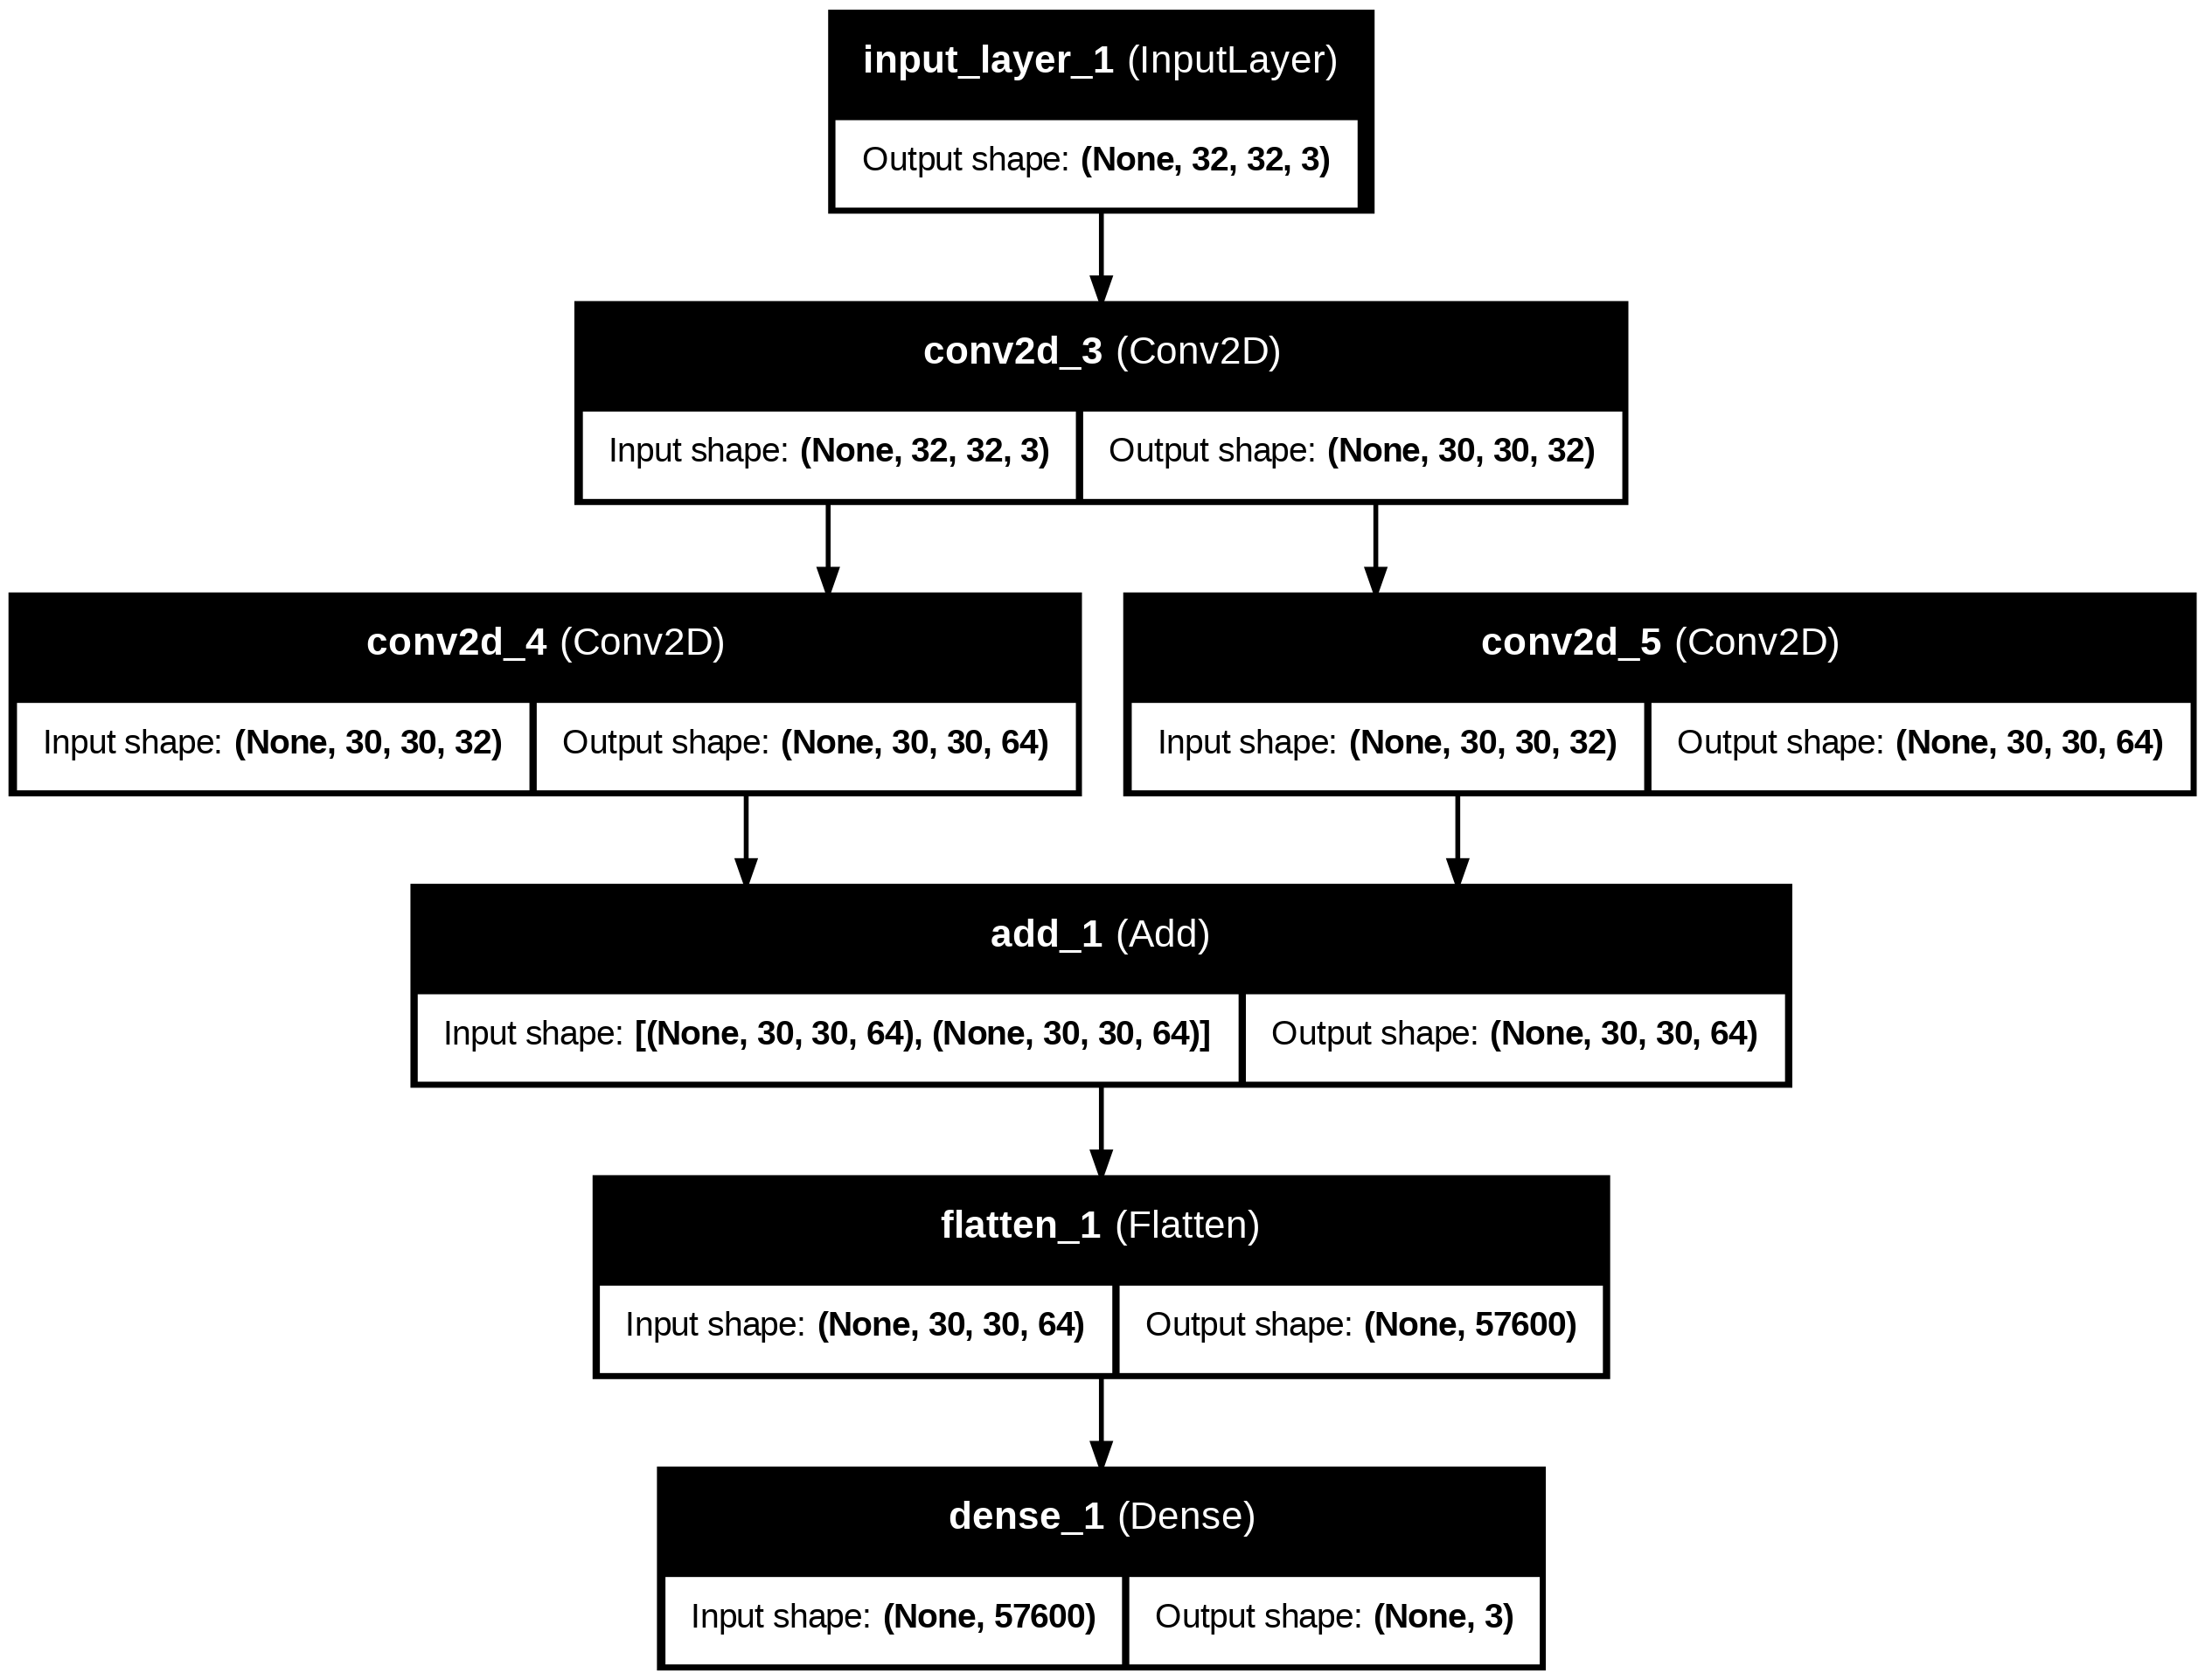

In [ ]:
# Keras:  Residual block where the number of filters changes
import keras

# Input layer: RGB image 32×32
inputs = keras.layers.Input(shape=(32, 32, 3))

# Convolutional layer
x = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
residual = x      # save this as the shortcut connection (residual)

# Main path with a different number of filters (32 → 64)
x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)

# Adjust the shortcut (residual) to match the new shape using a 1×1 convolution
residual = keras.layers.Conv2D(64, kernel_size=(1, 1))(residual)

# Add the main and shortcut paths together
x = keras.layers.Add()([x, residual])

# Head of the model
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(3, activation='softmax')(x)

# Create the model
model = keras.models.Model(inputs=inputs, outputs=outputs)

# Display the model summary
model.summary()

keras.utils.plot_model(model, to_file="functional_model.png", show_shapes=True, show_layer_names=True)
from IPython.display import Image, display
display(Image(filename="functional_model.png", width=800))

### Notes
- The shortcut path ensures that the input signal is preserved and gradients can flow easily.
- When the number of filters changes, we must use a 1×1 convolution to align the dimensions before adding.
- This type of block is commonly called a "projection shortcut" (used in ResNet when dimensions differ).

## Residual Block with Downsampling (Pooling in the Main Path)
- This example demonstrates how to implement a residual connection when the main path includes a MaxPooling layer (i.e., when spatial dimensions are reduced).
- In this case, we must also downsample the shortcut path to match the new spatial resolution and depth (number of filters).

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 30, 30,    │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 30, 30,    │     18,496 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 15, 15,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 15, 15,    │      2,112 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 15, 15,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 14400)     │          0 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │     43,203 │ flatten_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 64,707 (252.76 KB)

 Trainable params: 64,707 (252.76 KB)

 Non-trainable params: 0 (0.00 B)

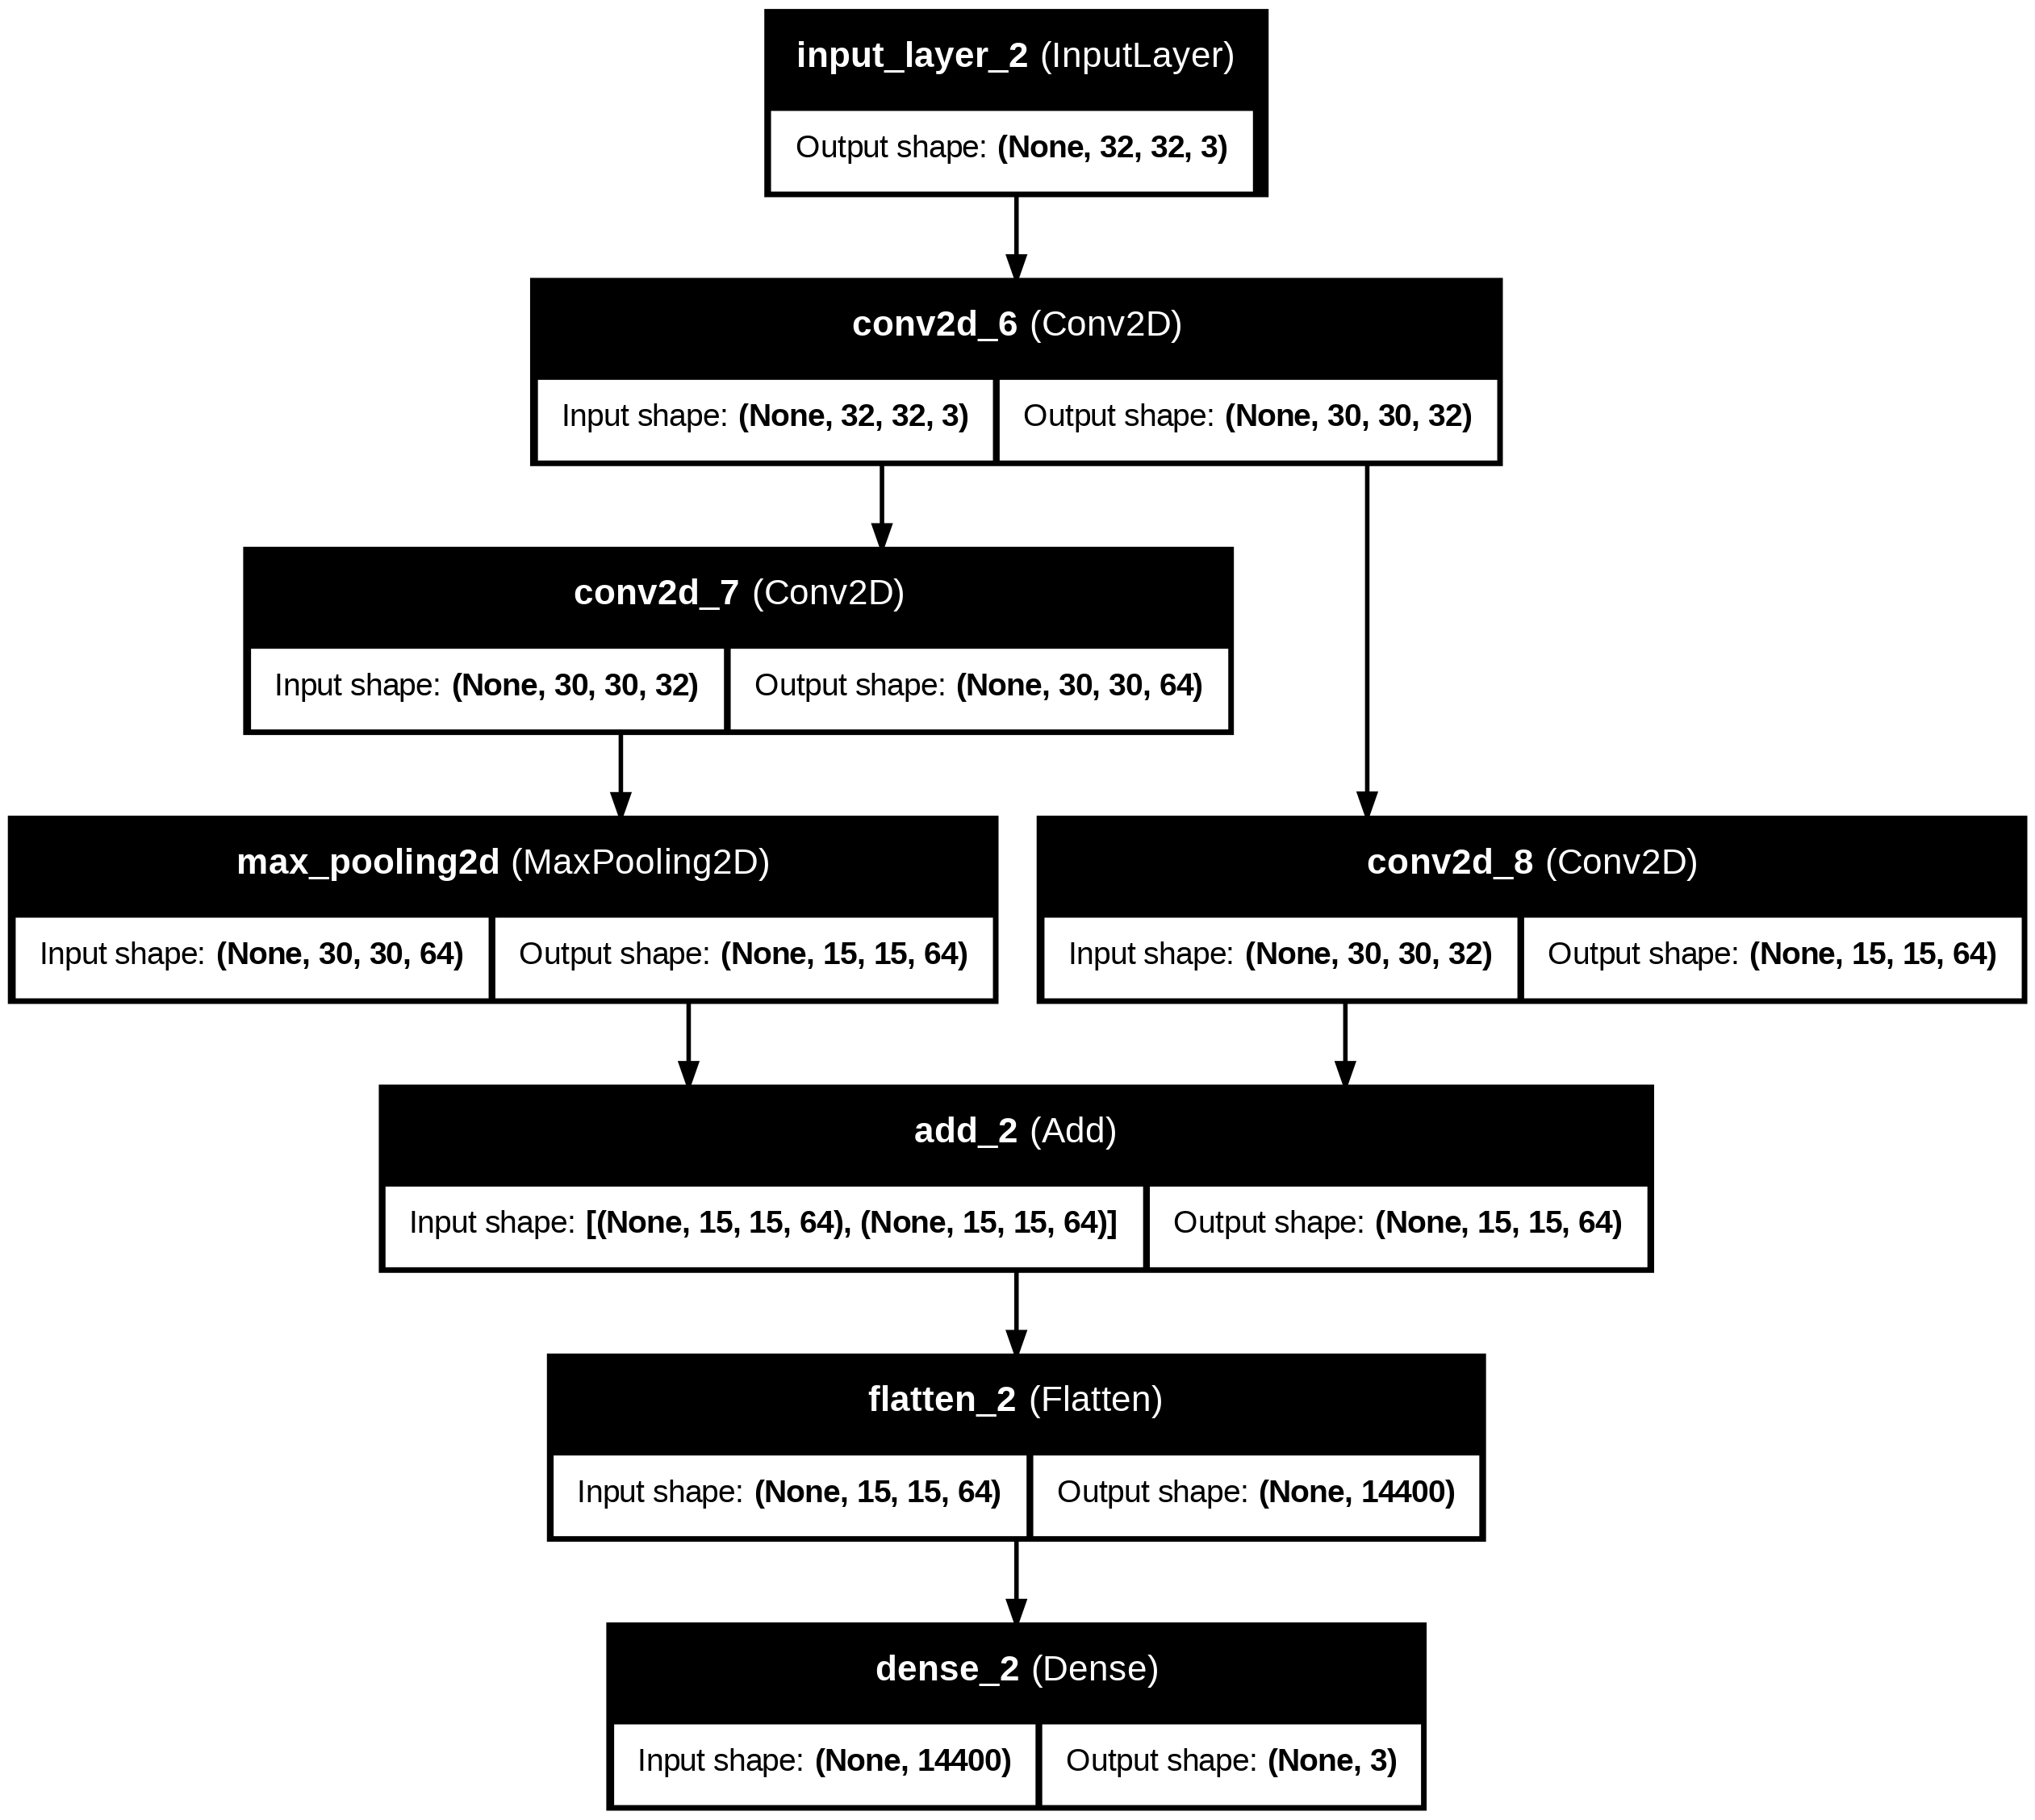

In [ ]:
# Keras:  Case where target block includes a pooling layer
import keras

# Input layer: RGB image 32×32
inputs = keras.layers.Input(shape=(32, 32, 3))

# Convolutional layer
x = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
residual = x # save this as the shortcut connection (residual)

# Main path: a convolutional block (convolutional layer followed by max-poolong layer)
x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = keras.layers.MaxPooling2D(2, padding="same")(x)

# Shortcut path adjustment
# To match both the new depth (32→64) and reduced spatial size (stride=2)
residual = keras.layers.Conv2D(64, kernel_size=(1, 1), strides=2)(residual)

# Add the main and shortcut paths together
x = keras.layers.Add()([x, residual])

# Head of the model
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(3, activation='softmax')(x)

# Create the model
model = keras.models.Model(inputs=inputs, outputs=outputs)

# Display the model summary
model.summary()

keras.utils.plot_model(model, to_file="functional_model.png", show_shapes=True, show_layer_names=True)
from IPython.display import Image, display
display(Image(filename="functional_model.png", width=800))

### Notes
- When the main path includes downsampling (e.g., pooling or stride > 1 convolution),
the shortcut path must also downsample to keep tensor shapes compatible.
- This adjustment is done using a 1×1 convolution with stride = 2.
- This type of residual connection is called a **"projection shortcut with downsampling"**.
It’s commonly used in deeper ResNet variants (e.g., ResNet-50, ResNet-101).

## Mini-ResNet: CNN Built from Custom Residual Blocks
- This example combines several types of residual blocks (with and without pooling)
to build a compact ResNet-style convolutional network.
- Each block automatically adjusts the shortcut path depending on whether pooling or filter change occurs.

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 32, 32, 3) │          0 │ input_layer_4[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │        896 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │      9,248 │ conv2d_12[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 16,    │        128 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 16, 16,    │          0 │ max_pooling2d_1[… │
│                     │ 32)               │            │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 16,    │     18,496 │ add_4[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 16, 16,    │     36,928 │ conv2d_15[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 64)  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 8, 8, 64)  │      2,112 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 8, 8, 64)  │          0 │ max_pooling2d_2[… │
│                     │                   │            │ conv2d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 8, 8, 128) │    147,584 │ conv2d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 8, 8, 128) │      8,320 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 8, 8, 128) │          0 │ conv2d_19[0][0],  │
│                     │                   │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ add_6[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │        129 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 297,697 (1.14 MB)

 Trainable params: 297,697 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

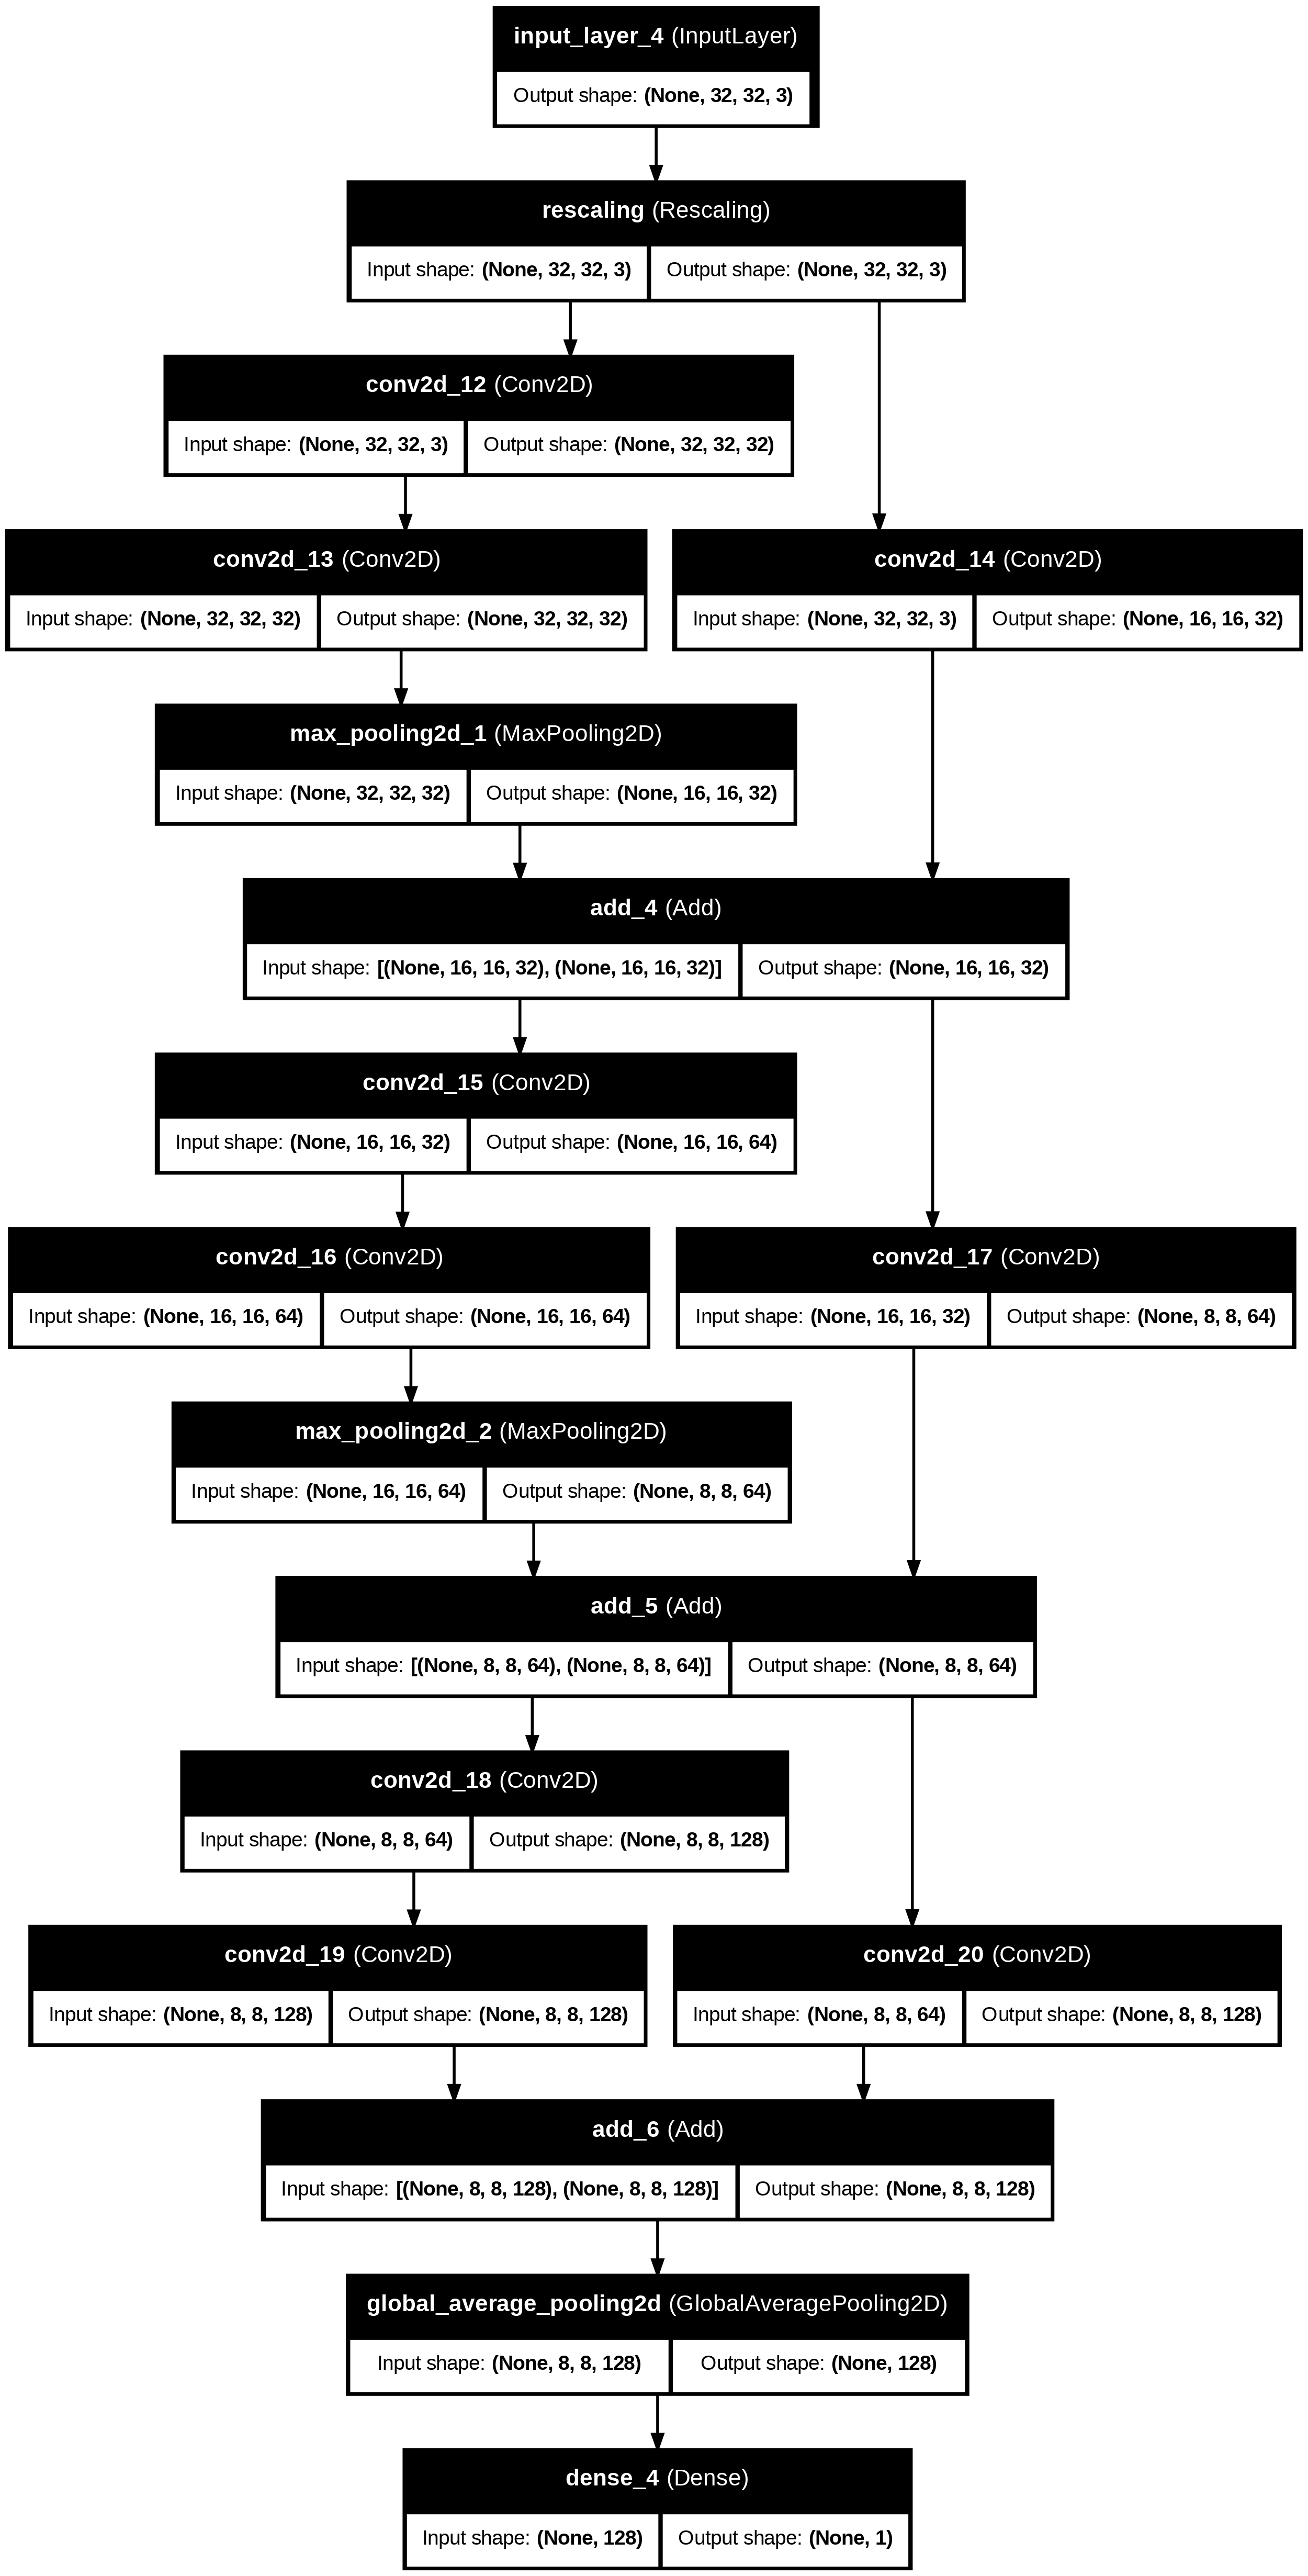

In [ ]:
import keras
from keras import layers

# Input and normalization
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

# Residual block definition
def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

# --- Stack of residual blocks ---
x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

# Model Head
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Build the model
model = keras.Model(inputs=inputs, outputs=outputs)

# Display the model summary
model.summary()

keras.utils.plot_model(model, to_file="functional_model.png", show_shapes=True, show_layer_names=True)
from IPython.display import Image, display
display(Image(filename="functional_model.png", width=800))

### Notes:
- This small model demonstrates how different types of residual blocks can be combined:
  - The first two include pooling (downsampling shortcuts).
  - The last one keeps dimensions constant (identity shortcut).
- The design follows a bipyramidal structure, similar to ResNet-18.
- The network is compact but effective — suitable for small datasets such as \textbf{Cats vs Dogs small}.
- The use of \texttt{GlobalAveragePooling2D} replaces dense flattening and helps reduce overfitting.
- You can easily expand this structure into deeper networks by stacking more residual blocks.

## Depthwise Separable Convolution

In [ ]:
import keras
from keras import layers, models

inputs = layers.Input(shape=(128, 128, 3))

# Standard convolution
x1 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)

# Depthwise separable convolution (factorized)
x2 = layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu')(inputs)

# Model summaries for comparison
model_std = models.Model(inputs, x1, name="standard_conv")
model_sep = models.Model(inputs, x2, name="separable_conv")

print("Standard Conv2D parameters:", model_std.count_params())
print("SeparableConv2D parameters:", model_sep.count_params())


Standard Conv2D parameters: 1792
SeparableConv2D parameters: 283


In [ ]:
model_sep.summary()

#keras.utils.plot_model(model_sep, show_shapes=True)

Model: "separable_conv"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_10             │ (None, 128, 128, 64)   │           283 │
│ (SeparableConv2D)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283 (1.11 KB)

 Trainable params: 283 (1.11 KB)

 Non-trainable params: 0 (0.00 B)

### Notes – Depthwise Separable Convolutions
- A standard Conv2D layer applies each filter to all input channels, and then sums them up.
- This means its computational cost grows with both the number of filters and input channels.
-  A SeparableConv2D layer splits this into two steps:
   - Depthwise convolution: one filter per input channel (spatial filtering only).
   - Pointwise ($1\times1$) convolution: combines the filtered channels into new feature maps.
- This factorization drastically reduces the number of parameters and computations,
especially when the number of input channels is large.
- Despite being much lighter, separable convolutions retain most of the representational power,
which is why they are used in architectures like Xception, MobileNet, and EfficientNet.
- In our demo, the parameter count for SeparableConv2D should be 5–10× smaller
than for a standard Conv2D with the same configuration.

## Mini Xception-like Network (Depthwise Separable CNN with Residual Connections)

- This network demonstrates the core ideas behind the Xception architecture:
  - replacing standard convolutions with depthwise separable convolutions,
  - combining them with residual connections,
  - and applying Batch Normalization and Dropout for stability and regularization.

In [ ]:
import keras
from keras import layers

# Input and normalization
inputs = keras.Input(shape=(180, 180, 3))
# x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)

# Initial convolution
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

# Stack of Xception-style residual blocks
for size in [32, 64, 128, 256, 512]:
    residual = x

    # Depthwise separable conv block
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    # Downsampling
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual to match dimensions
    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    # Add shortcut connection
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

keras.utils.plot_model(model, to_file="functional_model.png", show_shapes=True, show_layer_names=True)
from IPython.display import Image, display
display(Image(filename="functional_model.png", width=800))

### Notes
- Each block combines:
  - two depthwise separable convolutions,
  - batch normalization + ReLU activation,
  - residual connection with downsampling.
- This design is heavily inspired by Xception (Chollet, 2017) and MobileNet, which aim for high accuracy at low computational cost.
- **Depthwise separable convolutions** dramatically reduce parameter count while keeping accuracy competitive.
- The network scales progressively (32 → 512 filters) and ends with GlobalAveragePooling + Dropout to prevent overfitting.

## Summary

In this notebook, we have built and analyzed several CNN architecture patterns:

- **Residual blocks** help preserve gradient flow in deep networks, making training easier and faster to converge.
- **Projection shortcuts** allow residual connections even when the number of filters or feature map size changes.
- **Depthwise separable convolutions** factorize standard convolutions into two simpler operations (depthwise + pointwise),
  drastically reducing the number of parameters and computation.

By combining these concepts, we can create efficient yet powerful CNNs —
a principle behind architectures such as **ResNet**, **Xception**, and **MobileNet**.

